In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import re
from wordcloud import WordCloud

# STOP WORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer

import string
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels
import function as f

english_punctuations = string.punctuation
punctuations_list = english_punctuations

#remove stopwords 
STOPWORDS = set(stopwords.words('english'))

sentiment_to_number = {
    "sadness" : 0,
    "worry" : 1,
    "anger" :	2,
    "neutral" : 3,
    "enthusiasm" : 4,	
    "happiness": 4,
    "love" : 5
}

number_to_sentiment = {
    0 : "sadness",
    1 : "worry",
    2 : "anger",
    3 : "neutral",
    4 : "happiness",
    5 : "love"
}
from tweet import get_tweets 

[nltk_data] Downloading package stopwords to /Users/habbi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
def plot_confusion_matrix(y_test, y_pred):
    labels = unique_labels(y_test)
    column = [f'Predicted {number_to_sentiment[label]}' for label in labels]
    indices = [f'Actual {number_to_sentiment[label]}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = column, index = indices)

    plt.figure(figsize=(10,10))
    sns.heatmap(table, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()

## Read and Load the Dataset

In [54]:
df = pd.read_csv('../data/tweet_emotions.csv')
#display(df)

#merge with go emotion dataset
# df = df.drop("tweet_id", axis=1)
# go_emotion_df = pd.read_csv('../data/goemotion.csv').drop('index', axis=1)
# df = pd.concat([df, go_emotion_df], axis=0)

# df.to_csv(path_or_buf='../data/tweet_emotions.csv', index_label=False, header=True)

## Data Analysis

In [55]:
print(df.columns)
# null value check
print(np.sum(df.isnull().any(axis=1)))
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Index(['sentiment', 'content'], dtype='object')
0
Count of columns in the data is:   2
Count of rows in the data is:   85235


# Data Visualization

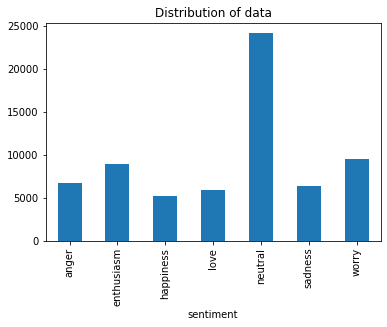

In [56]:
df['sentiment'] = df['sentiment'].apply(lambda x : x if x in ["sadness", "worry", "anger", "neutral", "enthusiasm", "happiness","love"] else None)
ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)

# Data Preprocessing&nbsp;

In [57]:
# data qu'on veut analyser
df = df.dropna()
data_preprocessed = df[['content','sentiment']]
data_preprocessed = data_preprocessed[data_preprocessed.sentiment != "empty"]

In [58]:
# remove stop word
data_preprocessed['content'] = data_preprocessed['content'].apply(lambda text: f.cleaning_tweet(text))

#tokenization
tokenizer = RegexpTokenizer(r'\w+|$[0-9]+|\S+')
data_preprocessed['content'] = data_preprocessed['content'].apply(
    lambda x: tokenizer.tokenize(x)
)

In [59]:
# replace sentiment with numbers
sentiment_to_number = {
    "sadness" : 0,
    "worry" : 1,
    "anger" :	2,
    "neutral" : 3,
    "enthusiasm" : 4,	
    "happiness": 4,
    "love" : 5
}

data_preprocessed['sentiment'] = data_preprocessed['sentiment'].replace(to_replace = sentiment_to_number)

In [60]:
data_preprocessed.groupby('sentiment').count()

content
sentiment         
0             6350
1             9527
2             6665
3            24108
4            14173
5             5856

In [61]:
data_preprocessed.to_csv(path_or_buf='../data/cleaned_tweet_emotions.csv', index_label=False, header=True)

In [62]:
# input feature (X) = content and label (Y) = sentiment
X = data_preprocessed['content'].astype(str)
y = data_preprocessed['sentiment']

## Train and Test sets

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 100)
np.save("../data/xtrain", X_train)

## TF-IDF Vectorizer

In [64]:
vectorizer= TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [65]:
print('No. of feature_words: ', len(vectorizer.get_feature_names()))

No. of feature_words:  304554


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## MODEL BUILDING

In [66]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
y_pred1 = BNBmodel.predict(X_test)

filename = './models/bnb_model.sav'
pickle.dump(BNBmodel, open(filename, 'wb'))

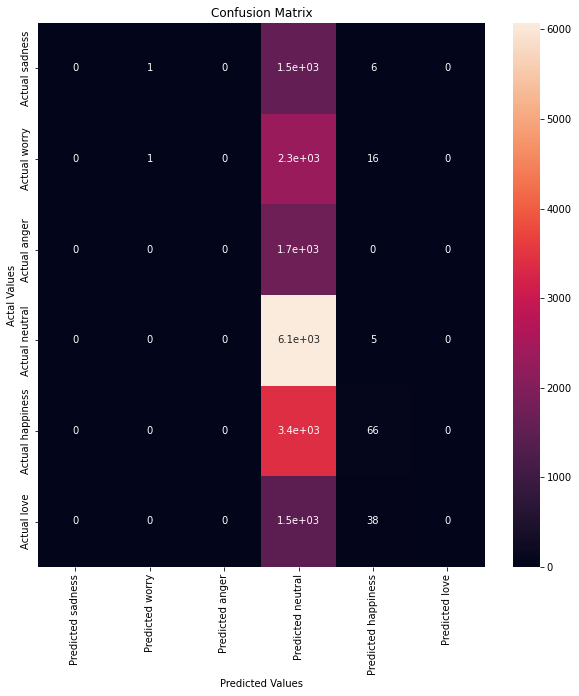

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1553
           1       0.50      0.00      0.00      2356
           2       0.00      0.00      0.00      1705
           3       0.37      1.00      0.54      6075
           4       0.50      0.02      0.04      3473
           5       0.00      0.00      0.00      1508

    accuracy                           0.37     16670
   macro avg       0.23      0.17      0.10     16670
weighted avg       0.31      0.37      0.20     16670



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [67]:
# confusion matrix 
plot_confusion_matrix(y_test, y_pred1)
print(classification_report(y_test, y_pred1))

### SVM

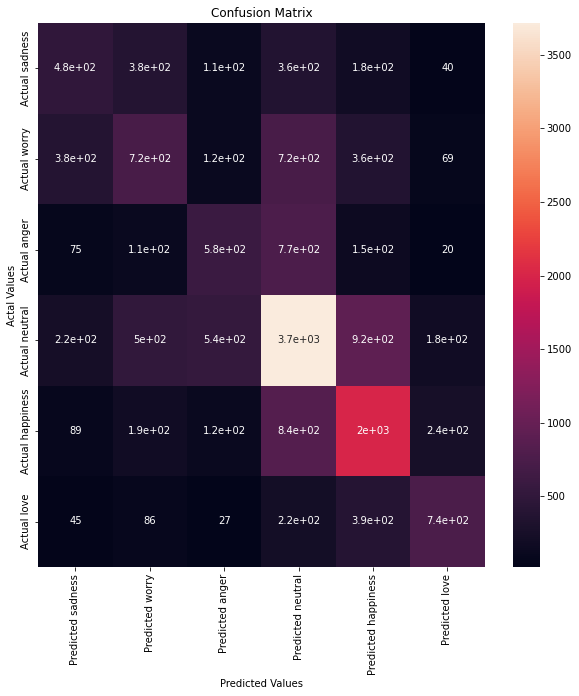

              precision    recall  f1-score   support

           0       0.37      0.31      0.34      1553
           1       0.36      0.30      0.33      2356
           2       0.39      0.34      0.37      1705
           3       0.56      0.61      0.59      6075
           4       0.50      0.58      0.54      3473
           5       0.57      0.49      0.53      1508

    accuracy                           0.49     16670
   macro avg       0.46      0.44      0.45     16670
weighted avg       0.49      0.49      0.49     16670



In [68]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
# model_evaluate(SVCmodel, X_test)
y_pred2 = SVCmodel.predict(X_test)

filename = './models/svc_model.sav'
pickle.dump(SVCmodel, open(filename, 'wb'))

# confusion matrix 
plot_confusion_matrix(y_test, y_pred2)
print(classification_report(y_test, y_pred2))

### Logistic Regression

In [69]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
# model_evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

FileNotFoundError: [Errno 2] No such file or directory: '/models/lr_model.sav'

In [70]:

filename = './models/lr_model.sav'
pickle.dump(LRmodel, open(filename, 'wb', ))

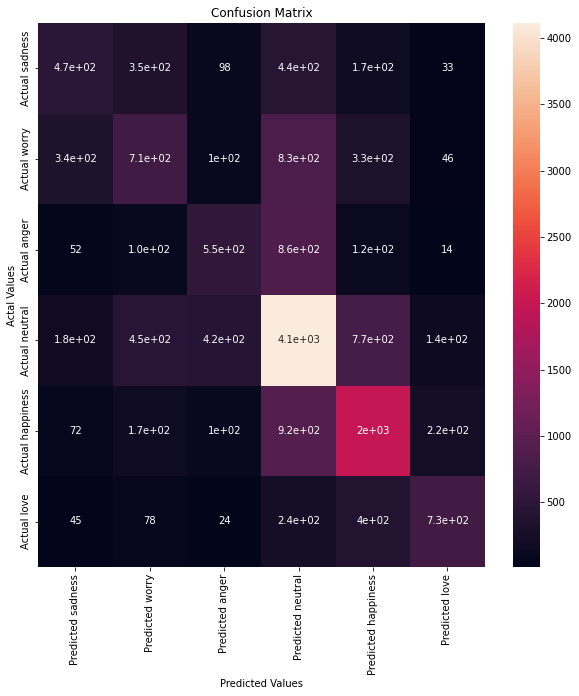

              precision    recall  f1-score   support

           0       0.40      0.30      0.34      1553
           1       0.38      0.30      0.34      2356
           2       0.43      0.32      0.37      1705
           3       0.56      0.68      0.61      6075
           4       0.53      0.57      0.55      3473
           5       0.61      0.48      0.54      1508

    accuracy                           0.51     16670
   macro avg       0.48      0.44      0.46     16670
weighted avg       0.50      0.51      0.50     16670



In [71]:
# confusion matrix 
plot_confusion_matrix(y_test, y_pred3)
print(classification_report(y_test, y_pred3))

# Word cloud

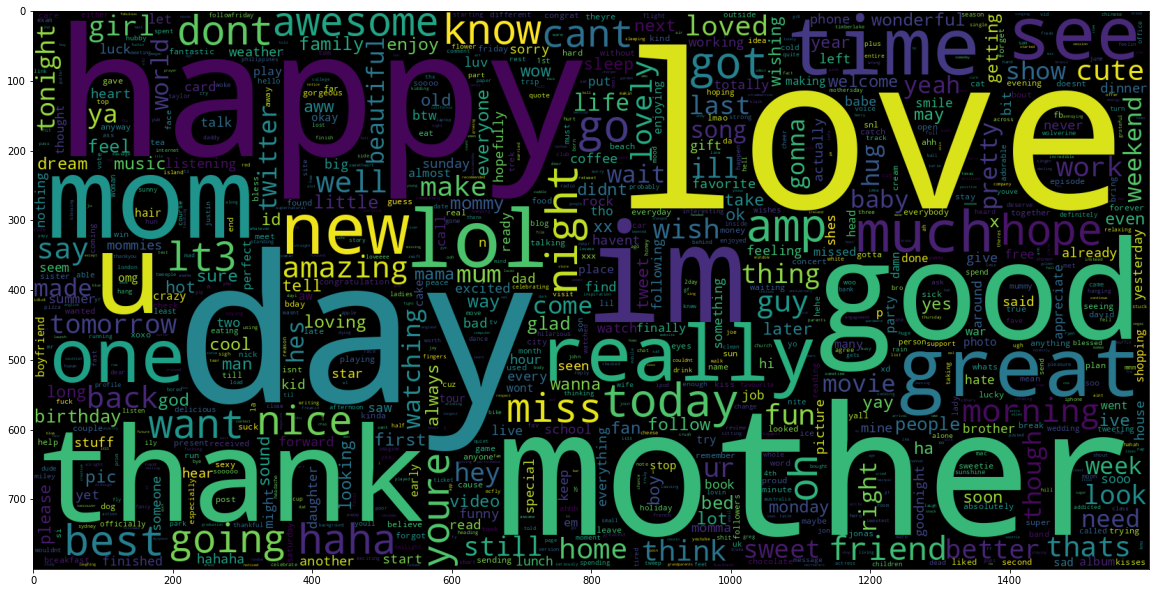

In [ ]:
data_test = data_preprocessed['content'][:40000]
df_sadness = data_preprocessed[data_preprocessed['sentiment'] == "sadness"]
df_hate = data_preprocessed[data_preprocessed['sentiment']=='hate']
df_worry = data_preprocessed[data_preprocessed['sentiment']=='worry']
df_love = data_preprocessed[data_preprocessed['sentiment']=='love']
data_sadness = df_sadness['content'][:10000]
data_hate = df_hate['content'][:10000]
data_worry = df_worry['content'][:10000]
data_love = df_love['content'][:10000]


f.display_word_cloud(data_test)